## Deep Convolutional GAN 실습해보기

- data : MNIST

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import os

# device setting for gpu users
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)
torch.backends.cudnn.enabled = False

device:  cuda


### 2. DATA LOAD

In [6]:
epochs = 100
batch_size = 256
z_dim = 100

transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(), transforms.Normalize(mean = (0.5, ),std=(0.5, ))])
mnist_dataset = datasets.MNIST(root = './data/', train = True, transform=transform, download=True)
dataloader = DataLoader(mnist_dataset, batch_size = batch_size, shuffle=True, drop_last=True, num_workers = 8)

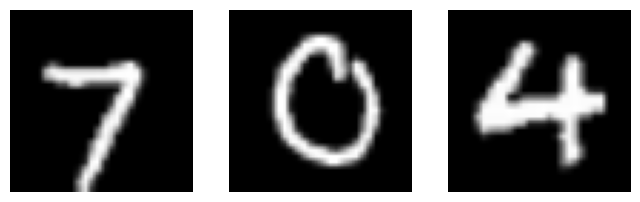

In [7]:
#Random visualization 잘 로드 되었나!
figure = plt.figure(figsize=(8,8))
cols, rows = 3,1
for i in range(1, cols*rows+1):
    #0 이상 len미만의 정수중 무작위 1개 선정 -> Tensor로 반환
    # .item() 하나의 값만인 텐서에서 정수를 꺼내 int/float로 반환
    sample_idx = torch.randint(len(mnist_dataset), size=(1,)).item() 
    img, label = mnist_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off") #hide x axis, y axis
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

### 3.Modeling

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dims):
        super(Generator, self).__init__()
        self.latent_dims = latent_dims
        
        # DCGAN Generator 구조 (논문 그림과 동일)
        # 100z -> Project and reshape to 4x4x1024 (BatchNorm + ReLU 추가)
        self.project = nn.Sequential(
            nn.Linear(latent_dims, 4 * 4 * 1024, bias=False),
            nn.BatchNorm1d(4 * 4 * 1024),
            nn.ReLU(True)
        )
        
        # 4x4x1024 -> 8x8x512 (CONV1)
        self.conv1 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        
        # 8x8x512 -> 16x16x256 (CONV2)
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        
        # 16x16x256 -> 32x32x128 (CONV3)
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        
        # 32x32x128 -> 64x64x1 (CONV4) - Output layer (BatchNorm 제외)
        self.conv4 = nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False)
        
        self.initialize_weights()

    def initialize_weights(self):
        # 모든 weights의 mean=0, std=0.02로 초기화
        for m in self.modules():
            if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z):
        # Project and reshape
        x = self.project(z)
        x = x.view(x.size(0), 1024, 4, 4)
        
        # CONV1: ReLU 사용 (output layer 제외)
        x = F.relu(self.bn1(self.conv1(x)), inplace=True)
        
        # CONV2: ReLU 사용
        x = F.relu(self.bn2(self.conv2(x)))
        
        # CONV3: ReLU 사용
        x = F.relu(self.bn3(self.conv3(x)))
        
        # CONV4 (Output): Tanh 사용, BatchNorm 제외
        x = torch.tanh(self.conv4(x))
        
        return x

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_size = 64):
        super(Discriminator, self).__init__()
        self.input_size = input_size
        
        # DCGAN Discriminator 구조
        # 64x64x1 -> 32x32x128 (CONV1) - input layer (BatchNorm 제외)
        self.conv1 = nn.Conv2d(1, 128, 4, stride=2, padding=1, bias=False)
        
        # 32x32x128 -> 16x16x256 (CONV2)
        self.conv2 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        
        # 16x16x256 -> 8x8x512 (CONV3)
        self.conv3 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(512)
        
        # 8x8x512 -> 4x4x1024 (CONV4)
        self.conv4 = nn.Conv2d(512, 1024, 4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(1024)
        
        # 4x4x1024 -> 1x1x1 (Final)
        self.conv5 = nn.Conv2d(1024, 1, 4, stride=1, padding=0, bias=False)
        
        self.initialize_weights()

    def initialize_weights(self):
        # 모든 weights의 mean=0, std=0.02로 초기화
        for m in self.modules():
            if isinstance(m, (nn.ConvTranspose2d, nn.Conv2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # 입력 차원 체크 및 변환
        if x.dim() == 2:  
            # MNIST 28x28 flatten된 경우
            side_len = int(x.size(1) ** 0.5)
            x = x.view(x.size(0), 1, side_len, side_len)
        elif x.dim() == 3:  
            x = x.unsqueeze(1)

        # 입력 크기를 64x64로 조정
        if x.size(-1) != self.input_size:
            x = F.interpolate(x, size=self.input_size, mode='bilinear', align_corners=False)
            
        # CONV1: LeakyReLU(0.2), BatchNorm 제외 (input layer)
        x = F.leaky_relu(self.conv1(x), 0.2, inplace=True)
        
        # CONV2: LeakyReLU(0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, inplace=True)
        
        # CONV3: LeakyReLU(0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, inplace=True)
        
        # CONV4: LeakyReLU(0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, inplace=True)
        
        # Final: Sigmoid
        x = torch.sigmoid(self.conv5(x))
        
        return x.view(-1, 1)

In [10]:
generator = Generator(latent_dims = z_dim).to(device)
discriminator = Discriminator(input_size=64).to(device)
print("Generator :", generator)
print("Discriminator :",discriminator)

Generator : Generator(
  (project): Sequential(
    (0): Linear(in_features=100, out_features=16384, bias=False)
    (1): BatchNorm1d(16384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator : Discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), 

### 4.train

In [11]:
class CheckpointManager:
    def __init__(self, save_dir="checkpoints"):
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
    
    def save_checkpoint(self, epoch, generator, discriminator, gen_optimizer, dis_optimizer, gen_losses, dis_losses):
        checkpoint_path = os.path.join(self.save_dir, f"checkpoint_ver2_epoch_{epoch}.pth")
        torch.save({
            'epoch': epoch,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'gen_optimizer_state_dict': gen_optimizer.state_dict(),
            'dis_optimizer_state_dict': dis_optimizer.state_dict(),
            'gen_losses': gen_losses,
            'dis_losses': dis_losses
        }, checkpoint_path)
    
    def load_checkpoint(self, checkpoint_path, generator, discriminator, gen_optimizer, dis_optimizer):
        checkpoint = torch.load(checkpoint_path)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        gen_optimizer.load_state_dict(checkpoint['gen_optimizer_state_dict'])
        dis_optimizer.load_state_dict(checkpoint['dis_optimizer_state_dict'])
        return checkpoint['epoch'] + 1, checkpoint['gen_losses'], checkpoint['dis_losses']

In [12]:

# 수정된 학습 함수
def train_model(latent_dims, discriminator, generator, batch_size, dis_optimizer, gen_optimizer, 
                      criterion, dataloader, epochs, device, save_every=10, resume_from=None):
    
    checkpoint_manager = CheckpointManager()
    
    start_epoch = 0
    dis_loss_list = []
    gen_loss_list = []
    
    if resume_from:
        start_epoch, gen_loss_list, dis_loss_list = checkpoint_manager.load_checkpoint(
            resume_from, generator, discriminator, gen_optimizer, dis_optimizer)
    
    fixed_noise = torch.randn(5, latent_dims).to(device)

    try:
        for epoch in range(start_epoch, epochs):
            epoch_dis_loss = 0.0
            epoch_gen_loss = 0.0
            num_batches = 0

            for batch_idx, (real_images, _) in enumerate(dataloader):
                num_batches += 1
                real_images = real_images.to(device)
                batch_size_current = real_images.size(0)

                # Label smoothing 적용 (중요!)
                real_labels = torch.ones(batch_size_current, 1).to(device) * 0.9
                fake_labels = torch.zeros(batch_size_current, 1).to(device) + 0.1

                ## DISCRIMINATOR 학습 (격에폭으로 줄임) ##
                if epoch % 2 == 0:  # 짝수 에폭에서만 Discriminator 학습
                    discriminator.zero_grad()
                    
                    real_output = discriminator(real_images)
                    d_loss_real = criterion(real_output, real_labels)
                    
                    noise = torch.randn(batch_size_current, latent_dims).to(device)
                    fake_images = generator(noise).detach()
                    fake_output = discriminator(fake_images)
                    d_loss_fake = criterion(fake_output, fake_labels)
                    
                    d_loss = (d_loss_real + d_loss_fake) * 0.5
                    d_loss.backward()
                    dis_optimizer.step()
                else:
                    d_loss = torch.tensor(0.0)  # Discriminator 업데이트 안함

                ## GENERATOR 학습 (2번 연속) ##
                for _ in range(2):  # Generator를 2번 학습
                    generator.zero_grad()
                    noise = torch.randn(batch_size_current, latent_dims).to(device)
                    fake_images = generator(noise)
                    fake_output = discriminator(fake_images)
                    g_loss = criterion(fake_output, torch.ones(batch_size_current, 1).to(device))
                    g_loss.backward()
                    gen_optimizer.step()

                epoch_dis_loss += d_loss.item()
                epoch_gen_loss += g_loss.item()

            dis_loss_list.append(epoch_dis_loss / num_batches)
            gen_loss_list.append(epoch_gen_loss / num_batches)

            print(f"EPOCH {epoch}: D_Loss: {dis_loss_list[-1]:.4f}, G_Loss: {gen_loss_list[-1]:.4f}")

            if epoch % save_every == 0:
                checkpoint_manager.save_checkpoint(epoch, generator, discriminator, gen_optimizer, dis_optimizer, gen_loss_list, dis_loss_list)

            if epoch % 20 == 0:
                with torch.no_grad():
                    fake_images = generator(fixed_noise)
                    fake_images = fake_images.cpu().detach()
                    fake_images = (fake_images + 1) / 2.0
                    fake_images = torch.clamp(fake_images, 0, 1)

                    plt.figure(figsize=(10,5))
                    plt.title("GENERATED IMAGE, EPOCH {}".format(epoch))
                    for i in range(5):
                        plt.subplot(1, 5, int(i) + 1)
                        plt.imshow(fake_images[i].squeeze(), cmap='gray')
                        plt.axis('off')
                    plt.show()

    except KeyboardInterrupt:
        checkpoint_manager.save_checkpoint(epoch, generator, discriminator, gen_optimizer, dis_optimizer, gen_loss_list, dis_loss_list)

    return discriminator, generator, dis_loss_list, gen_loss_list

In [13]:
criterion = nn.BCELoss()
generator_optim = torch.optim.Adam(generator.parameters(), lr = 0.0002, betas = (0.5, 0.999)) 
discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas = (0.5, 0.999))

In [14]:
#진짜 (1), 가짜(0)의 라벨을 붙여준다.
discriminator, generator, dis_losses, gen_losses = train_model(z_dim, discriminator, generator, batch_size, discriminator_optim, generator_optim, criterion, dataloader, epochs, device)

In [ ]:
torch.save(generator.state_dict(), 'DC_G.ckpt')
torch.save(discriminator.state_dict(), 'DC_D.ckpt')

In [ ]:
# Loss그래프 그리기
import matplotlib.pyplot as plt
plt.plot(dis_losses, label="Discriminator Loss")
plt.plot(gen_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Losses over Training")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'dis_losses' is not defined

In [ ]:
def debug_train_model(latent_dims, discriminator, generator, 
                      batch_size, dis_optimizer, gen_optimizer, 
                      criterion, dataloader, epochs, device):
    
    print("=== 디버깅 모드 학습 시작 ===")
    print(f"Device: {device}")
    print(f"Dataset size: {len(dataloader.dataset)}")
    print(f"Batch size: {batch_size}")
    print(f"Number of batches: {len(dataloader)}")
    
    # GPU 메모리 확인
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")
    
    # 고정된 노이즈 (시각화용)
    fixed_noise = torch.randn(5, latent_dims).to(device)
    
    # 첫 번째 배치 테스트
    print("\n첫 번째 배치 로딩 테스트...")
    start_time = time.time()
    first_batch = next(iter(dataloader))
    load_time = time.time() - start_time
    print(f"첫 배치 로드 시간: {load_time:.2f}초")
    print(f"배치 shape: {first_batch[0].shape}")
    
    # Forward pass 테스트
    print("\nForward pass 테스트...")
    with torch.no_grad():
        test_noise = torch.randn(4, latent_dims).to(device)
        test_fake = generator(test_noise)
        test_output = discriminator(test_fake)
        print(f"Generator 출력: {test_fake.shape}")
        print(f"Discriminator 출력: {test_output.shape}")
    
    # Loss 기록용 리스트
    dis_loss_list = []
    gen_loss_list = []

    for epoch in range(min(epochs, 3)):  # 처음 3 에폭만 테스트
        print(f"\n=== EPOCH {epoch} 시작 ===")
        epoch_start = time.time()
        epoch_dis_loss = 0.0
        epoch_gen_loss = 0.0
        num_batches = 0

        for batch_idx, (real_images, _) in enumerate(dataloader):
            batch_start = time.time()
            num_batches += 1
            
            # 실제 이미지를 디바이스로 이동
            real_images = real_images.to(device)
            batch_size_current = real_images.size(0)

            # 레이블 생성
            real_labels = torch.ones(batch_size_current, 1).to(device)
            fake_labels = torch.zeros(batch_size_current, 1).to(device)

            ## DISCRIMINATOR 학습 ##
            discriminator.zero_grad()
            
            # 실제 이미지에 대한 판별
            real_output = discriminator(real_images)
            d_loss_real = criterion(real_output, real_labels)
            
            # 가짜 이미지 생성 및 판별
            noise = torch.randn(batch_size_current, latent_dims).to(device)
            fake_images = generator(noise).detach()
            fake_output = discriminator(fake_images)
            d_loss_fake = criterion(fake_output, fake_labels)
            
            # Discriminator 총 손실
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            dis_optimizer.step()

            ## GENERATOR 학습 ##
            generator.zero_grad()
            
            # 새로운 가짜 이미지 생성
            noise = torch.randn(batch_size_current, latent_dims).to(device)
            fake_images = generator(noise)
            fake_output = discriminator(fake_images)
            
            # Generator 손실
            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            gen_optimizer.step()

            # 손실 누적
            epoch_dis_loss += d_loss.item()
            epoch_gen_loss += g_loss.item()
            
            batch_time = time.time() - batch_start
            
            # 매 10 배치마다 출력
            if batch_idx % 10 == 0:
                print(f"  Batch {batch_idx:3d}/{len(dataloader)}: "
                      f"D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}, "
                      f"Time: {batch_time:.2f}s")
                
                # GPU 메모리 사용량
                if torch.cuda.is_available():
                    memory_used = torch.cuda.memory_allocated() / 1024**3
                    print(f"    GPU 메모리: {memory_used:.2f}GB")
            
            # 처음 몇 배치만 테스트
            if batch_idx >= 50:  # 50 배치만 실행
                print(f"  50 배치 완료, 다음 에폭으로...")
                break

        # Epoch 평균 손실
        avg_d_loss = epoch_dis_loss / num_batches
        avg_g_loss = epoch_gen_loss / num_batches
        dis_loss_list.append(avg_d_loss)
        gen_loss_list.append(avg_g_loss)
        
        epoch_time = time.time() - epoch_start
        print(f"EPOCH {epoch} 완료: D_Loss: {avg_d_loss:.4f}, G_Loss: {avg_g_loss:.4f}, "
              f"Time: {epoch_time:.1f}s")

        # 이미지 생성 테스트
        with torch.no_grad():
            fake_images = generator(fixed_noise)
            fake_images = fake_images.cpu().detach()
            fake_images = (fake_images + 1) / 2.0
            fake_images = torch.clamp(fake_images, 0, 1)
            print(f"생성된 이미지 범위: {fake_images.min():.3f} ~ {fake_images.max():.3f}")

        # GPU 메모리 정리
        torch.cuda.empty_cache()

    print("\n=== 디버깅 완료 ===")
    return discriminator, generator, dis_loss_list, gen_loss_list

# 디버깅 실행
import time

print("현재 설정:")
print(f"z_dim: {z_dim}")
print(f"batch_size: {batch_size}")
print(f"epochs: {epochs}")



현재 설정:
z_dim: 100
batch_size: 512
epochs: 100


In [ ]:
# 디버깅 모드로 실행
discriminator, generator, dis_losses, gen_losses = debug_train_model(
    z_dim, discriminator, generator, batch_size, 
    discriminator_optim, generator_optim, criterion, 
    dataloader, epochs, device
)

=== 디버깅 모드 학습 시작 ===
Device: cuda
Dataset size: 60000
Batch size: 512
Number of batches: 117
GPU: NVIDIA TITAN RTX
GPU 메모리: 23.6GB

첫 번째 배치 로딩 테스트...


첫 배치 로드 시간: 0.77초
배치 shape: torch.Size([512, 1, 64, 64])

Forward pass 테스트...
Generator 출력: torch.Size([4, 1, 64, 64])
Discriminator 출력: torch.Size([4, 1])

=== EPOCH 0 시작 ===
  Batch   0/117: D_loss: 0.0000, G_loss: 66.5983, Time: 1.48s
    GPU 메모리: 0.43GB
  Batch  10/117: D_loss: 0.0000, G_loss: 66.5871, Time: 1.52s
    GPU 메모리: 0.43GB
  Batch  20/117: D_loss: 0.0000, G_loss: 66.6164, Time: 1.79s
    GPU 메모리: 0.43GB
  Batch  30/117: D_loss: 0.0000, G_loss: 66.4479, Time: 1.89s
    GPU 메모리: 0.43GB
  Batch  40/117: D_loss: 0.0000, G_loss: 66.5232, Time: 1.89s
    GPU 메모리: 0.43GB


KeyboardInterrupt: 

### 5.Evaluation

In [ ]:
G = Generator(latent_dims=z_dim).to(device)
G.load_state_dict(torch.load("/root/Internship/checkpoints/checkpoint_ver2_epoch_50.pth", map_location=device))
G.eval()  # 평가 모드로 설정

NameError: name 'Generator' is not defined

In [ ]:
# 100개의 latent 벡터 생성 (배치 크기=100)
z = torch.randn(100, 100).to(device)  # [batch_size, z_dim]

with torch.no_grad():
    fake_images = G(z)  # shape: [100, 1, 28, 28]


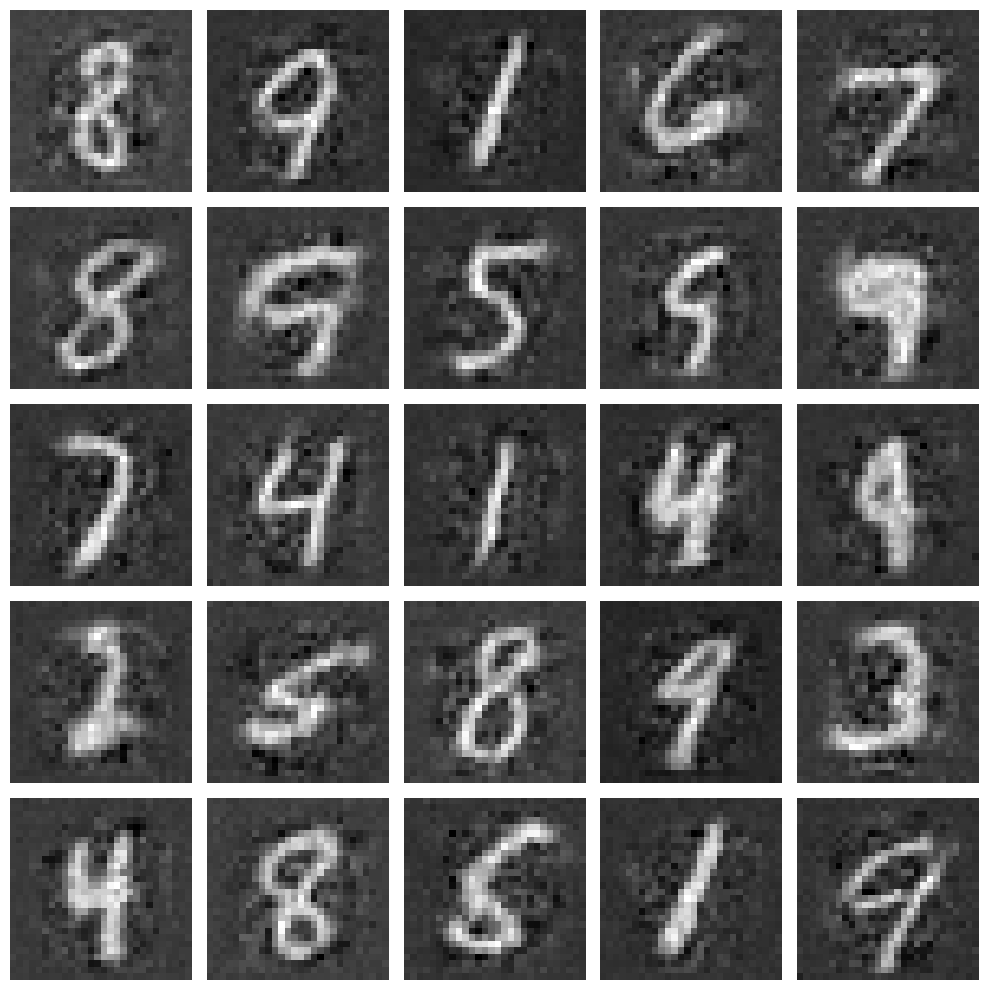

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(fake_images[i].cpu().reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()